In [11]:
def compare_date_components(day_doc, month_doc, year_doc, day_req, month_req, year_req):
    """Compare two date components, handling None values in the request."""
    # Convert all to int for doc, but req can be None
    if year_req is not None:
        if int(year_doc) < int(year_req):
            return -1
        elif int(year_doc) > int(year_req):
            return 1
    if month_req is not None:
        if int(month_doc) < int(month_req):
            return -1
        elif int(month_doc) > int(month_req):
            return 1
    if day_req is not None:
        if int(day_doc) < int(day_req):
            return -1
        elif int(day_doc) > int(day_req):
            return 1
    return 0

def compare_dates(date_doc, date_requete):
    """
    Compare une date de document à une requête de date, en tenant compte des champs manquants (None).
    """
    # Split the document date into components
    day_doc, month_doc, year_doc = date_doc.split('/')
    day_doc, month_doc, year_doc = int(day_doc), int(month_doc), int(year_doc)

    # If no restriction, always True
    if all(date_requete.get(k) is None for k in ["début", "fin", "précis", "not"]):
        return True

    # Handle "not"
    not_req = date_requete.get("not")
    if not_req is not None:
        jn, mn, an = not_req.get("j"), not_req.get("m"), not_req.get("a")
        match = True
        if an is not None and int(year_doc) != int(an):
            match = False
        if mn is not None and int(month_doc) != int(mn):
            match = False
        if jn is not None and int(day_doc) != int(jn):
            match = False
        if match:
            return False

    # Handle "précis"
    precis = date_requete.get("précis")
    if precis is not None:
        jp, mp, ap = precis.get("j"), precis.get("m"), precis.get("a")
        match = True
        if ap is not None and int(year_doc) != int(ap):
            match = False
        if mp is not None and int(month_doc) != int(mp):
            match = False
        if jp is not None and int(day_doc) != int(jp):
            match = False
        return match

    res = True
    # Handle "début"
    debut = date_requete.get("début")
    if debut is not None:
        jd, md, ad = debut.get("j"), debut.get("m"), debut.get("a")
        cmp = compare_date_components(day_doc, month_doc, year_doc,
                                      int(jd) if jd is not None else None,
                                      int(md) if md is not None else None,
                                      int(ad) if ad is not None else None)
        if cmp < 0:
            res = False

    # Handle "fin"
    fin = date_requete.get("fin")
    if fin is not None:
        jf, mf, af = fin.get("j"), fin.get("m"), fin.get("a")
        cmp = compare_date_components(day_doc, month_doc, year_doc,
                                      int(jf) if jf is not None else None,
                                      int(mf) if mf is not None else None,
                                      int(af) if af is not None else None)
        if cmp > 0:
            res = False

    return res

In [84]:
import pandas as pd
import ast
#rubrique et dates dans others.csv
# mots_clés dans text_title.csv

'''
    resultats = {
        "return": None,
        "mots_cles": {"yes": [], "no": None},
        "operateurs_mots_cles": None,
        "rubrique": None,
        "operateurs_rubrique": None,
        "dates": {"debut": None, "fin": None, "précis": None, "not": None},
        "titre": None,
        "operateurs_titre": None,
        "images": None
    }

'''
def recherche_documents(resultats, index_inverse_texte, index_inverse_date, index_inverse_rubrique, index_inverse_titre, index_inverse_image):
    """
    Fonction qui recherche les documents correspondant, dans lemmes_path, aux résultats de la requete (resultats).
    :param resultats: dictonnaires contenant les résultats de la requête
    :param index_inverse_mots_cles: fichier csv index inversé des mots-clés
    :param index_inverse_dates_rubriques: fichier csv index inversé des dates et rubriques
    :return: Liste de documents correspondant aux résultats de la requête
    """
    docs_cherches = []

    #partie mots-clés (sans les not)
    mots_cles = resultats["mots_cles"]
    if len(mots_cles["yes"]) != 0:
        dict_match_key = {}
        index_texte = pd.read_csv(index_inverse_texte, sep= "\t")
        for mot in mots_cles["yes"]:
            #print("mot:", mot)        
            docs_qui_matchs = index_texte.loc[index_texte["mot"] == mot.strip(), "docs"].values
            #print("docs_qui_matchs:", docs_qui_matchs)
            if len(docs_qui_matchs) != 0:
                docs_qui_matchs = docs_qui_matchs[0]
                dict_match_key[mot] = docs_qui_matchs
            #print(f"docs_qui_matchs: {docs_qui_matchs}")
        
        if len(dict_match_key.keys())== 1:
            docs_key = list(set(e.strip() for e in ast.literal_eval(list(dict_match_key.values())[0])))
        else:
            if resultats["operateurs_mots_cles"] == "ou":
 
                docs_key = list(set().union(*(set(e.strip() for e in ast.literal_eval(l)) for l in list(dict_match_key.values()))))
            else:  
                docs_key = list(set().intersection(*(set(e.strip() for e in ast.literal_eval(l)) for l in list(dict_match_key.values()))))

        if len(docs_cherches) == 0:
            docs_cherches = docs_key
        else:
            docs_cherches = list(set(e.strip() for e in docs_cherches) & set(e.strip() for e in docs_key))

    print("doc_cherches post mots_clés:", docs_cherches)
    #partie titre
    titres = resultats["titre"]
    if titres != None:
        dict_match_titre = {}
        index_titre = pd.read_csv(index_inverse_titre, sep='\t')
        if not isinstance(titres, list):
            titres = [titres]
        for titre in titres:
            for tr in [" ", '"', "'", "'"]:
                while tr in titre:
                    titre = titre.replace(tr, '')
            docs_qui_matchs = index_titre.loc[index_titre["mot"] == titre, "docs"].values
            if len(docs_qui_matchs) > 0:
                docs_qui_matchs = docs_qui_matchs[0]
                dict_match_titre[titre] = docs_qui_matchs
            else:
                print(f"⚠️ titre introuvable : {titre}")
 

        if len(dict_match_titre.keys()) == 1:
            docs_titre = list(set(e.strip() for e in ast.literal_eval(list(dict_match_titre.values())[0])))
        else:
            if resultats["operateurs_titre"] == "ou":
                docs_titre = list(set().union(*(set(e.strip() for e in ast.literal_eval(l)) for l in list(dict_match_titre.values()))))

            else:
                docs_titre = list(set.intersection(*(set(e.strip() for e in ast.literal_eval(l)) for l in dict_match_titre.values())))

        
        if len(docs_cherches) == 0:
            docs_cherches = docs_titre
        else:
            docs_cherches = list(set(e.strip() for e in docs_cherches) & set(e.strip() for e in docs_titre))
    print("doc_cherches post titre:", docs_cherches)

    #partie rubrique
    rubriques = resultats["rubrique"]
    if rubriques != None:
        print(rubriques)
        dict_match_rubrique = {}
        index_rubrique = pd.read_csv(index_inverse_rubrique, sep='\t')
        if not isinstance(rubriques, list):
            liste = [rubriques.strip()]
            rubriques = liste
        for rubrique in rubriques:
            rubrique = rubrique.strip()
            docs_matchs = index_rubrique.loc[index_rubrique["mot"] == rubrique, "docs"].values
            if len(docs_matchs) > 0:
                docs_qui_matchs = docs_matchs[0]
                dict_match_rubrique[rubrique] = docs_qui_matchs
            else:
                print(f"⚠️ Rubrique introuvable : {rubrique}")
            
        if len(dict_match_rubrique.keys()) == 1:
            docs_rubrique = list(set(e.strip() for e in ast.literal_eval(list(dict_match_rubrique.values())[0])))
        else:
            #dict_match_rubrique[rubrique] = docs_qui_matchs
            if resultats["operateurs_rubrique"] == "ou":
                docs_rubrique = list(set().union(*(set(e.strip() for e in ast.literal_eval(l)) for l in list(dict_match_rubrique.values()))))
            else:
                docs_rubrique = list(set().intersection(*(set(e.strip() for e in ast.literal_eval(l)) for l in list(dict_match_rubrique.values()))))
        print("docs_rubrique:", docs_rubrique)
        if len(docs_cherches) == 0:
            docs_cherches = docs_rubrique
        else:
            docs_cherches = list(set(docs_cherches) & set(docs_rubrique))
    print("doc_cherches post rubrique:", docs_cherches)

    #partie images
    image = resultats["images"]
    if image != None:
        index_image = pd.read_csv(index_inverse_image, sep='\t')
        docs_match_image = index_image.loc[index_image["mot"] == "yes", "docs"].values[0]
        if len(docs_cherches) == 0:
            docs_cherches = docs_match_image
        else:
            docs_cherches = list(set(docs_cherches) & set(docs_match_image))
    print("doc_cherches post images:", docs_cherches)

    #partie date
    date = resultats["dates"]
    if date["début"] != None or date["fin"] != None or date["précis"] != None or date["not"] != None:
        index_date = pd.read_csv(index_inverse_date, sep='\t')
        docs_dates = []
        for _, row in index_date.iterrows():
            #print("dates ____________________")
            date_doc_comp = row["mot"]
            
            if compare_dates(date_doc=date_doc_comp, date_requete= date):
                docs_qui_matchs = ast.literal_eval(row["docs"])
                docs_dates = []
                if len(docs_dates) == 0:
                    docs_dates = docs_qui_matchs 
                else:
                    docs_dates = list(set(e.strip() for e in docs_dates) | set(e.strip() for e in docs_qui_matchs))
                #print(docs_dates)
        if docs_dates:
            if len(docs_cherches) == 0:
                docs_cherches = docs_dates
            else:
                docs_cherches = list(set(e.strip() for e in docs_cherches) & set(e.strip() for e in docs_dates))
    print("doc_cherches post dates:", docs_cherches)
    
    #partie not
    mot_cles_not = mots_cles["no"]
    if mot_cles_not != None:
        index_texte = pd.read_csv(index_inverse_texte, sep= "\t")
        docs_qui_matchs = index_texte.loc[index_texte["mot"] == mot_cles_not, "docs"].values[0]
        
        docs_cherches = list(set(e.strip() for e in docs_cherches) - set(e.strip() for e in docs_qui_matchs))

    print("doc_cherches post not:", docs_cherches)

    #partie return_value
    if resultats["return"] != "rubriques":
        return docs_cherches
    else:
        rubriques_cherches = []
        index_rubrique = pd.read_csv(index_inverse_rubrique, sep='\t')
        for _, rubrique in index_rubrique.iterrows():
            for doc in docs_cherches:
                if doc in ast.literal_eval(rubrique["docs"]):
                    rubriques_cherches.append(rubrique["mot"])
        return set(rubriques_cherches)


In [83]:
from td5 import *
from td6 import *

if __name__ == "__main__":
    # extraction des informations de la requete
    requete = input("Entrez votre requête en langage naturel : ")
    print("Requête initiale :", requete)
    print("---------------------------------------------")

    resultat = traiter_requete(requete)

    # correction orthographique des mots clés
    
    lemmes_path = "lemmes_lower.csv"
    if resultat["mots_cles"]["no"] != None:
        print("mots b4 correction: ",resultat["mots_cles"]["no"])
        resultat["mots_cles"]["no"] = correction_orthographique(resultat["mots_cles"]["no"], lemmes_path)
    
    for i in range(len(resultat["mots_cles"]["yes"])):
        print("mots b4 correction: ", resultat["mots_cles"]["yes"][i])
        resultat["mots_cles"]["yes"][i] = correction_orthographique(resultat["mots_cles"]["yes"][i], lemmes_path)
    
    print("Requête corrigée :")
    print(resultat)
    print("-------------------------------------------")

    index_inverse_texte = "../TD4/reverse_index_texte.csv"
    index_inverse_date = "../TD4/reverse_index_date.csv"
    index_inverse_rubrique = "../TD4/reverse_index_rubrique.csv"
    index_inverse_titre = "../TD4/reverse_index_titre.csv"
    index_inverse_image = "../TD4/reverse_index_image.csv"

    # recherche des documents pertinents
    documents = recherche_documents(resultat, index_inverse_texte, index_inverse_date, index_inverse_rubrique, index_inverse_titre, index_inverse_image)
    print(documents)


Requête initiale : 
---------------------------------------------


ValueError: min() iterable argument is empty

In [85]:
index_inverse_texte = "../TD4/reverse_index_texte.csv"
index_inverse_date = "../TD4/reverse_index_date.csv"
index_inverse_rubrique = "../TD4/reverse_index_rubrique.csv"
index_inverse_titre = "../TD4/reverse_index_titre.csv"
index_inverse_image = "../TD4/reverse_index_image.csv"

def traiter_et_rechercher(requete):
    """
    Traite une requête en langage naturel, effectue la correction orthographique,
    puis recherche les documents pertinents.
    """
    print("Requête initiale :", requete)
    print("---------------------------------------------")

    resultat = traiter_requete(requete)

    # correction orthographique des mots clés
    if resultat["mots_cles"]["no"] is not None:
        print("mots b4 correction: ", resultat["mots_cles"]["no"])
        resultat["mots_cles"]["no"] = correction_orthographique(resultat["mots_cles"]["no"], lemmes_path)

    for i in range(len(resultat["mots_cles"]["yes"])):
        print("mots b4 correction: ", resultat["mots_cles"]["yes"][i])
        resultat["mots_cles"]["yes"][i] = correction_orthographique(resultat["mots_cles"]["yes"][i], lemmes_path)

    print("Requête corrigée :")
    print(resultat)
    print("-------------------------------------------")

    # recherche des documents pertinents
    documents = recherche_documents(
        resultat,
        index_inverse_texte,
        index_inverse_date,
        index_inverse_rubrique,
        index_inverse_titre,
        index_inverse_image
    )
    print(documents)
    return documents

In [86]:
import time
import pandas as pd

import matplotlib.pyplot as plt

def get_precision_recall(docs_predits, docs_pertinents):
    """
    Calcule la précision et le rappel pour une requête.
    """
    docs_predits_set = set(docs_predits)
    docs_pertinents_set = set(docs_pertinents)
    docs_pertinents_recuperes = docs_predits_set & docs_pertinents_set


    if not docs_predits_set and not docs_pertinents_set:
        precision = 1.0
        recall = 1.0
    elif not docs_predits_set and docs_pertinents_set:
        precision = 1.0
        recall = 0.0
    elif docs_predits_set and not docs_pertinents_set:
        precision = 0.0
        recall = 1.0
    else:
        precision = len(docs_pertinents_recuperes) / len(docs_predits_set)
        recall = len(docs_pertinents_recuperes) / len(docs_pertinents_set)

    return precision, recall

def get_all_precisions_recalls(requetes_10, docs_pertinents_manuel):
    """
    Pour chaque requête, calcule la précision et le rappel.
    """
    precisions = []
    rappels = []
    for req, docs_pert in zip(requetes_10, docs_pertinents_manuel):
        docs_predits = traiter_et_rechercher(req)
        precision, rappel = get_precision_recall(docs_predits, docs_pert)
        precisions.append(precision)
        rappels.append(rappel)
    return precisions, rappels

def measure_average_time(requetes_10, n=100):
    """
    Mesure le temps de réponse moyen du moteur sur n exécutions.
    """
    start = time.time()
    for _ in range(n):
        for req in requetes_10:
            traiter_et_rechercher(req)
    end = time.time()
    avg_time = (end - start) / (n * len(requetes_10))
    return avg_time

def display_results_table(requetes_10, precisions, rappels):
    """
    Affiche les résultats sous forme de tableau, avec F1-score.
    """
    f1_scores = []
    for p, r in zip(precisions, rappels):
        if p + r == 0:
            f1 = 0.0
        else:
            f1 = 2 * p * r / (p + r)
        f1_scores.append(f1)
    df = pd.DataFrame({
        'Requête': requetes_10,
        'Précision': precisions,
        'Rappel': rappels,
        'F1-score': f1_scores
    })
    print(df)
    return df, f1_scores

def plot_precision_recall_f1(precisions, rappels, f1_scores):
    """
    Affiche les mesures sous forme de graphiques.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(precisions, label='Précision', marker='o')
    plt.plot(rappels, label='Rappel', marker='x')
    plt.plot(f1_scores, label='F1-score', marker='s')
    plt.xlabel('Numéro de requête')
    plt.ylabel('Score')
    plt.title('Précision, rappel et F1-score par requête')
    plt.legend()
    plt.grid(True)
    plt.show()

def calculate_precision_rappel(requetes_10: list[str], docs_pertinents_manuel: list[list[str]]):
    '''
    fonction qui à partir de requetes_10, 10 requetes choisies, utilise traiter_et_rechercher pour obtenir les
    documents correspondants à la requete, puis compare ces documents à la liste des documents pertinents manuellement
    fournie.
    Cette fonction calcule donc pour chaque requete la précision, le rappel, et F-1 score.
    Elle mesure également le temps de réponse moyen du moteur sur 100 exécutions.
    Finalement, elle présente les mesures sous forme de tableaux et de graphiques.
    '''
    precisions, rappels = get_all_precisions_recalls(requetes_10, docs_pertinents_manuel)
    avg_time = measure_average_time(requetes_10, n=100)
    df, f1_scores = display_results_table(requetes_10, precisions, rappels)
    print(f"Temps de réponse moyen sur 100 exécutions : {avg_time:.4f} secondes")
    plot_precision_recall_f1(precisions, rappels, f1_scores)
    return df, precisions, rappels, f1_scores, avg_time

Requête initiale : Je veux les articles de la rubrique Focus parlant d’innovation.
---------------------------------------------
mots b4 correction:  innovation
Requête corrigée :
{'return': 'articles', 'mots_cles': {'yes': ['innovation'], 'no': None}, 'operateurs_mots_cles': None, 'rubrique': 'focus ', 'operateurs_rubrique': None, 'dates': {'début': None, 'fin': None, 'précis': None, 'not': None}, 'titre': None, 'operateurs_titre': None, 'images': None}
-------------------------------------------
doc_cherches post mots_clés: ['68279', '75457', '69536', '72395', '74750', '67795', '71359', '74167', '76212', '74171', '67561', '74172', '68393', '75465', '73876', '67946', '68383', '72933', '67068', '75790', '73879', '70168', '68273', '75466', '72633', '73689', '72392', '72937', '73190', '70753', '68642', '72120', '73882', '75068', '76213', '76507', '68882', '68276', '70751', '71840', '73687', '74752', '72122', '74176', '76209', '72400', '69533', '68639', '73182', '74748', '71361', '75065',

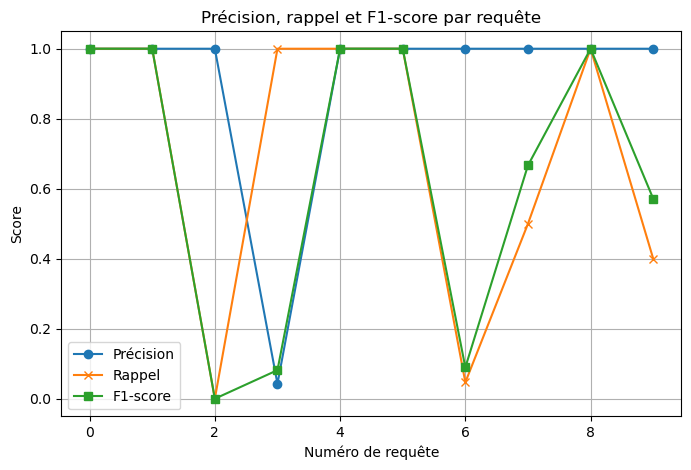

(                                             Requête  Précision    Rappel  \
 0  Je veux les articles de la rubrique Focus parl...   1.000000  1.000000   
 1  Je souhaite les rubriques des articles parlant...   1.000000  1.000000   
 2  Quels sont les articles sur la réalité virtuelle?   1.000000  0.000000   
 3  Je voudrais les articles qui parlent d’airbus ...   0.042553  1.000000   
 4      Je cherche les recherches sur l’aéronautique.   1.000000  1.000000   
 5  Article traitant des Serious Game et de la réa...   1.000000  1.000000   
 6  Je voudrais tous les bulletins écrits entre 20...   1.000000  0.046875   
 7  Quels sont les articles dont le titre contient...   1.000000  0.500000   
 8  je voudrais les articles dont le titre contien...   1.000000  1.000000   
 9  je veux voir les articles de la rubrique Focus...   1.000000  0.400000   
 
    F1-score  
 0  1.000000  
 1  1.000000  
 2  0.000000  
 3  0.081633  
 4  1.000000  
 5  1.000000  
 6  0.089552  
 7  0.666667  
 8  1

In [87]:
'''
pour récupérer 'manuellement' les documents pertinents, je regarde index inversés du td4 avec ctrl+F et je cherche le mots clés voulu
ou bien la rubrique voulue, etc...
Puis, je veille à bien effectuer manuellement les opérations entre les documents récupérés à chaque fois.
    Cela veut dire, faire correctement union lorsqu'il s'agit de "ou" et intersection sinon

Pour les dates, j'ai bien essayé à regarder tous les cas possibles (à partir de date X ou date entre X et Y)
et faire un union de tous les documents dont les dates correspondent aux contraintes.

Une approche plus correcte, que j'ai appliqué pour quelques requetes comme la 3eme où je pensais que mes résultats allaient étre faux
puisqu'on cherche un bimot 'réalité virtuelle' et non pas les deux mots séparés, je suis allé chercher directement dans le corpus avec un 
ctrl+F. Cette approche me semble plus sur et correcte pour avoir des résultats manuels fiables, mais elle consomme beaucoup de temps 
sur d'autres requetes. Donc, je l'ai malheureusement pas appliqué partout
'''

requetes_choisies = ["Je veux les articles de la rubrique Focus parlant d’innovation.",
                    "Je souhaite les rubriques des articles parlant de nutrition ou de vins.",
                    "Quels sont les articles sur la réalité virtuelle?",
                    "Je voudrais les articles qui parlent d’airbus ou du projet Taxibot.",
                    "Je cherche les recherches sur l’aéronautique.",
                    "Article traitant des Serious Game et de la réalité virtuelle.",
                    "Je voudrais tous les bulletins écrits entre 2012 et 2013 mais pas au mois de juin.",
                    "Quels sont les articles dont le titre contient le terme 'marché' et le mot 'projet'?",
                    "je voudrais les articles dont le titre contient le mot 3D.",
                    "je veux voir les articles de la rubrique Focus et publiés entre 30/08/2011 et 29/09/2011."
                     ]
resultats_manuels_requetes = [
    ['75457', '71359', '67795', '74167', '73876', '68383', '72933', '67068', '75790', '68273', '72392', '76507', '68882', '68276', '69533', '75065', '72113', '70162', '74744', '75789', '68274', '67938', '73182', '67383'], # requete 1
    ['du côté pôles', 'focus', 'au coeur régions', 'actualité innovation', 'actualités innovations', 'evénement'], #requete 2
    ['75064'], #requete 3
    ['70920', '72933', '71617', '72636'], #requete 4
    ['68888', '71840', '73687', '72636', '68392', '68280', '76207', '74167', '71358', '68393', '72113', '73884', '70914', '75792', '68383', '67068', '73879', '75066', '76510', '74745', '68642', '71615'], #requete 5
    [], #requete 6
    ['70922', '73437', '70743', '71618', '74171', '68889', '74172', '70915', '73876', '70918', '71845', '71835', '73875', '73877', '69811', '72392', '73683', '74175', '70167', '70161', '71840', '74752', '70920', '70923', '70749', '72400', '71839', '72114', '72630', '73434', '74173', '72113', '74452', '72940', '69819', '73690', '72938', '72634', '69812', '73432', '70164', '72396', '69182', '69540', '71616', '71836', '71837', '69539', '72118', '72394', '73684', '70752', '71838', '73686', '70169', '72939', '69537', '70746', '70170', '71841', '72401', '70753', '74749', '72120', '70747', '73882', '74174', '72631', '70751', '74176', '71357', '72632', '71842', '71358', '72932', '69184', '70921', '74451', '74449', '71843', '73438', '69541', '68886', '73878', '73431', '72635', '68888', '74746', '74168', '71619', '69536', '71617', '72636', '71366', '74454', '72395', '70916', '69820', '71359', '74456', '74750', '69816', '70165', '72116', '71614', '74457', '72933', '68884', '69542', '70168', '72936', '69817', '74747', '70163', '74745', '72937', '69185', '69180', '72121', '72393', '70166', '68887', '72122', '71612', '71360', '69533', '70919', '69538', '68883', '73884', '71363', '71362', '69815', '74455', '73436', '72119', '74751', '72115', '70744', '73880', '72397', '70745', '72637', '72398', '74167', '69181', '74450', '72399', '69177', '74170', '73433', '73879', '69821', '72934', '73688', '71621', '72633', '69534', '73689', '69813', '71615', '72935', '68882', '73687', '69535', '72117', '74169', '73685', '74748', '69814', '71361', '69543', '69178', '72629', '71620', '70914', '73435', '73881', '69179', '70917', '70162', '74744', '73883', '69186', '68885', '69183', '73430', '68881', '73691', '69818', '70748', '74453'], #requete 7
    ['72634', '72392'], #requete 8
    ['67554', '72635', '73431'], #requete 9
    ['67794', '67795', '67553', '67554', '67555'] #requete 10



]

calculate_precision_rappel(requetes_choisies, resultats_manuels_requetes)
